In [53]:
#%%


import logging
from binance.um_futures import UMFutures as Client
from binance.lib.utils import config_logging
from binance.error import ClientError
import dateparser
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from scipy import signal
from datetime import datetime


#%%


akey = os.environ.get("API_KEY")
asec = os.environ.get("API_SECRET")
futures_client = Client(key = akey, secret= asec)

#%%

#DATA PARAMETERS

PREFIX = os.getcwd()
BLOCK = 512
DUMP = '.csv'
DATA_DIR = os.path.join(PREFIX, "datasets")

#%%

TIMEFRAME = "1h"
PAIR = "ETHUSDT"
# FROM_DATE = "2022-01-14 01:00:00" 
# TO_DATE = "2022-10-05 01:00:00"
FROM_DATE = "2021-10-14" 
TO_DATE = "2022-10-17"
NUM_DATA = 250 #max 100k idk why

#%%

###

#PARAMETERS

DATA_WINDOW_LENGTH = BLOCK
ROLLING_WINDOW_LENGTH = 12 #this is correlated with the chosen TIMEFRAME and as such should be a function of that; something about the frequency of local minima and maxima
CALLBACKRATE_FACTOR = 10

###

dir_name = f"{NUM_DATA}_{PAIR}_{TIMEFRAME}_{FROM_DATE.replace(' ', '-').replace(':', '')}_{TO_DATE.replace(' ', '-').replace(':', '')}"

NEW_DATA_DIR = os.path.join(PREFIX, DATA_DIR, dir_name)

if not os.path.exists(NEW_DATA_DIR):
    os.makedirs(NEW_DATA_DIR)
print(NEW_DATA_DIR)    


import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, data_path, transform=None, target_transform=None):
        
        self.data_path
        self.read_labels_feats()
        self.transform = transform
        self.target_transform = target_transform

    def read_labels_feats(self):
                # any additional label treatment
        self.labels = pd.read_csv(self.data_path + "_labels.csv")
        self.labels.drop(['Unnamed: 0'], axis=1, inplace=True)
        
        #feature engineering
        self.features = pd.read_csv(self.data_path + "_features.csv")
        self.features.drop(['Unnamed: 0'], axis=1, inplace=True)
        self.features.drop(['close_time'], axis=1, inplace=True)
        self.features.drop(['labels'], axis=1, inplace=True)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx]

        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

c:\Users\igor-\.cloned\trailing_orders-1\DEV\datasets\250_ETHUSDT_1h_2021-10-14_2022-10-17


In [54]:
class StaticDatabase(Dataset):
    def __init__(self, client, pair, timeframe, from_date, to_date, contractType = 'PERPETUAL', limit=1000, transform=None, target_transform=None):

        self.transform = transform
        self.target_transform = target_transform
        
        self.client = client
        self.pair = pair
        self.timeframe = timeframe
        self.contractType = contractType
        self.limit = limit
        self.from_date = pd.Timestamp(from_date)
        self.to_date = pd.Timestamp(to_date)        
        self.from_ts = round(datetime.timestamp(pd.to_datetime(self.from_date, unit="ms")))*1000
        self.to_ts = round(datetime.timestamp(pd.to_datetime(self.to_date, unit="ms")))*1000
        self.data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.from_ts, limit = self.limit)) 
        # self.last_ts = round(datetime.timestamp(pd.to_datetime(self.data.iloc[-1]['close_time'], unit='ms')))   
        self.last_ts = self.data.iloc[-1]['timestamp']   
        self.length = len(self.data)
        # self.data = pd.DataFrame()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):

        feature = self.features.iloc[idx, :]
        label = self.labels.iloc[idx]

        if self.transform:
            feature = self.transform(feature)
        if self.target_transform:
            label = self.target_transform(label)
        return feature, label

    def get_historical_klines(self):

        # print(self.last_ts < self.to_ts)
        
        while (self.length < NUM_DATA) and (self.last_ts < self.to_ts):
            
            if self.length % 1000 == 0: print(self.last_ts < self.to_ts)
            # print(1)
            print(self.data.shape)        
            self.new_data = self.process_klines(self.client.continuous_klines(self.pair, self.contractType, self.timeframe, startTime = self.last_ts, limit=self.limit))
            self.data = pd.concat([self.data, self.new_data], axis=0).reset_index(drop=True)
            self.length = len(self.data)
            # print(self.data.iloc[-1]['timestamp'] > self.last_ts)
            self.last_ts = self.data.iloc[-1]['timestamp']
            
        # print(self.last_ts < self.to_ts)

        # self.dump_data()                    
                
    def process_klines(self, klines):
        df = pd.DataFrame(klines)
        df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_volume', 'taker_buy_quote_asset_volume', 'ignore']
        df['timestamp'] = df['open_time']
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df['open'] = pd.to_numeric(df['open'])
        df['high'] = pd.to_numeric(df['high'])
        df['low'] = pd.to_numeric(df['low'])
        df['close'] = pd.to_numeric(df['close'])
        df['volume'] = pd.to_numeric(df['volume'])
        df['quote_asset_volume'] = pd.to_numeric(df['quote_asset_volume'])
        df['trades'] = pd.to_numeric(df['trades'])
        df['taker_buy_volume'] = pd.to_numeric(df['taker_buy_volume'])
        df['taker_buy_quote_asset_volume'] = pd.to_numeric(df['taker_buy_quote_asset_volume'])
        df['ignore'] = pd.to_numeric(df['ignore'])
        df.drop(['ignore'], axis=1, inplace=True)
        # df.drop(['close_time'], axis=1, inplace=True)
        return df

    def make_features_and_labels(self):


        df = self.data
        


        D = 1
        t = 1
        win1 = signal.windows.hann(9)
        win2 = signal.windows.hann(6)
        
        
        ###

        #FEATURES
        
        df["closes_ema"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        df["closes_std"] = df.close.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).std()
        df["closes_z"] = (df.close - df.closes_ema) / df.closes_std
        df["closes_z"] = df.closes_z.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        
        ###

        features = self.data[
            ['open_time', 'open', 'high', 'low', 'close', 'volume',
             'quote_asset_volume', 'trades', 'taker_buy_volume',
              'taker_buy_quote_asset_volume', 'closes_ema', 'closes_std',
               'closes_z']
              ]

        self.features = features
        ###
        # self.features["closes_ema_2"] = df.closes_ema.ewm(halflife=pd.Timedelta(TIMEFRAME)/4, ignore_na=True, min_periods=ROLLING_WINDOW_LENGTH, times=df.open_time).mean()
        # self.features["filtered_closes_1"] = signal.convolve(self.features.close, win1, mode='same') / sum(win1)
        # self.features["filtered_closes_2"] = signal.convolve(self.features.close, win2, mode='same') / sum(win2)

        ###

        closes_1 = self.data.close.shift(-1)
        closes_2 = self.data.close.shift(-2)
        acc = ((self.features.close - closes_1) - (closes_1 - closes_2))/(D**2*t)
        self.features['acc'] = acc #this is pretty much noise
        self.features['filtered_acc'] = signal.convolve(self.features.acc, win2, mode='same') / sum(win2)
        self.features['filtered_acc'] = signal.convolve(self.features.acc, win1, mode='same') / sum(win1)
        
        ###

        filtered_z = signal.convolve(self.features.closes_z, win2, mode='same') / sum(win2)
        filtered_z = signal.convolve(self.features.closes_z, win1, mode='same') / sum(win1)
        self.features["filtered_z"] = filtered_z

        ###



        ###

        #LABELS
        
        mean_std = df.closes_std.mean()

        # peak_indexes, _ = signal.find_peaks(df.close.values, threshold=mean_std/2)
        # peak_indexes, _ = signal.find_peaks(df.close.values, prominence=1.5*mean_std)
        peak_indexes, _ = signal.find_peaks(df.close.values, prominence=2*mean_std)
        peak_regions = []
        
        for peak_index in peak_indexes:

            peak_regions.append(peak_index)

            for j in range(min(max(peak_index, len(df.close.values) - max(peak_indexes))-1, 5)):

                if peak_index+j >= len(df.close):
                    break

                if np.abs(df.close.values[peak_index-j] - df.close.values[peak_index]) < mean_std/3:

                    peak_regions.append(peak_index-j)
                elif np.abs(df.close.values[peak_index+j] - df.close.values[peak_index]) < mean_std/3:
                    peak_regions.append(peak_index+j)        



        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, threshold=mean_std/2)
        # valley_indexes, _ = signal.find_peaks(-1*df.close.values, prominence=1.5*mean_std)
        valley_indexes, _ = signal.find_peaks((-1)*df.close.values, prominence=2*mean_std)
        valley_regions = []
        
        for valley_index in valley_indexes:
            # for j in range(min(valley_index, len(df.close.values) - max(valley_indexes), 5)):
            for j in range(min(max(valley_index, len(df.close.values) - max(peak_indexes))-1, 5)):
                if np.abs(df.close.values[valley_index-j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index-j)
                elif np.abs(df.close.values[valley_index+j] - df.close.values[valley_index]) < mean_std/3:
                    valley_regions.append(valley_index+j)
                        
        labels = [1 if i in peak_regions else (-1 if i in valley_regions else 0) for i in range(len(df.close.values))]
        labels = pd.DataFrame(labels, columns=['labels'])
        
        self.labels = labels
        self.peak_regions = self.labels[self.labels == 1].dropna().index.values
        self.valley_regions = self.labels[self.labels == -1].dropna().index.values
        self.neutral_regions = self.labels[self.labels == 0].dropna().index.values        
        # df['peak_regions'] = peak_regions
        # df['valley_regions'] = valley_regions
        # self.data_alchemy()    


    def data_alchemy(self, *args, **kwargs):
        
        #FEATURE ENGINEERING
        
        df = self.data
        feat = self.features
        lab = self.labels

        self.data_alchemy(df, feat, lab)



    def plot_data(self, size = 250):
        df = self.data
        # df = self.data[0:size]
        # peak_regions = self.labels[[x == 1]]

        (fig1, ax1) = plt.subplots(figsize=(18,14))
        ax1.plot(df.closes_ema, "k-", label='closes_ema')
        # ax1.plot(self.features.closes_ema_2, "b-", linewidth=0.75, label='closes_ema_2')
        ax1.plot(df.closes_ema + 1.618*df.closes_std, "g--", linewidth=0.75)
        ax1.plot(df.closes_ema - 1.618*df.closes_std, "r--", linewidth=0.75)
        # ax1[1].plot(self.features.filtered_closes_1, linewidth=1.75)
        # ax1[1].plot(self.features.filtered_closes_2, linewidth=1.75)

        (fig2, ax2) = plt.subplots(figsize=(16,12))

        ax2.plot(df.close)
        peak_x = self.peak_regions
        peak_y = df.close.values[self.peak_regions]
        ax2.plot(peak_x, peak_y, marker='o', markersize=2.5, linestyle="None", color='green', label="Peaks")

        valley_x = self.valley_regions
        valley_y = df.close.values[self.valley_regions]
        ax2.plot(valley_x, valley_y, marker='o', markersize=2.5, linestyle="None", color='red', label="Valleys")
        ax2.grid(which='both', alpha=0.8)
        ax2.grid(True, which="minor")

        (fig3, axs) = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
        
        axs[0].plot(self.features.acc)
        axs[0].plot(self.features.filtered_acc, linewidth=1.75)
        
        axs[1].plot(self.features.closes_z)
        axs[1].plot(self.features.filtered_z, linewidth=1.75)

        self.dump_data()
        
        return (fig1, ax1), (fig2, ax2), (fig3, axs)


    def dump_data(self, dir_name=None):
        if DUMP == '.json':
            self.features.to_json(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}.json"))
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.json")) 
        elif DUMP == '.csv':
            self.features.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_features.csv"))    
            self.labels.to_csv(os.path.join(DATA_DIR, f"{PAIR}_{TIMEFRAME}_labels.csv")) 

In [55]:

sdb = StaticDatabase(futures_client, PAIR, TIMEFRAME, FROM_DATE, TO_DATE)
sdb.get_historical_klines()
sdb.make_features_and_labels()


C:\Users\igor-\AppData\Local\Temp\ipykernel_8128\2996668765.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.features['acc'] = acc #this is pretty much noise


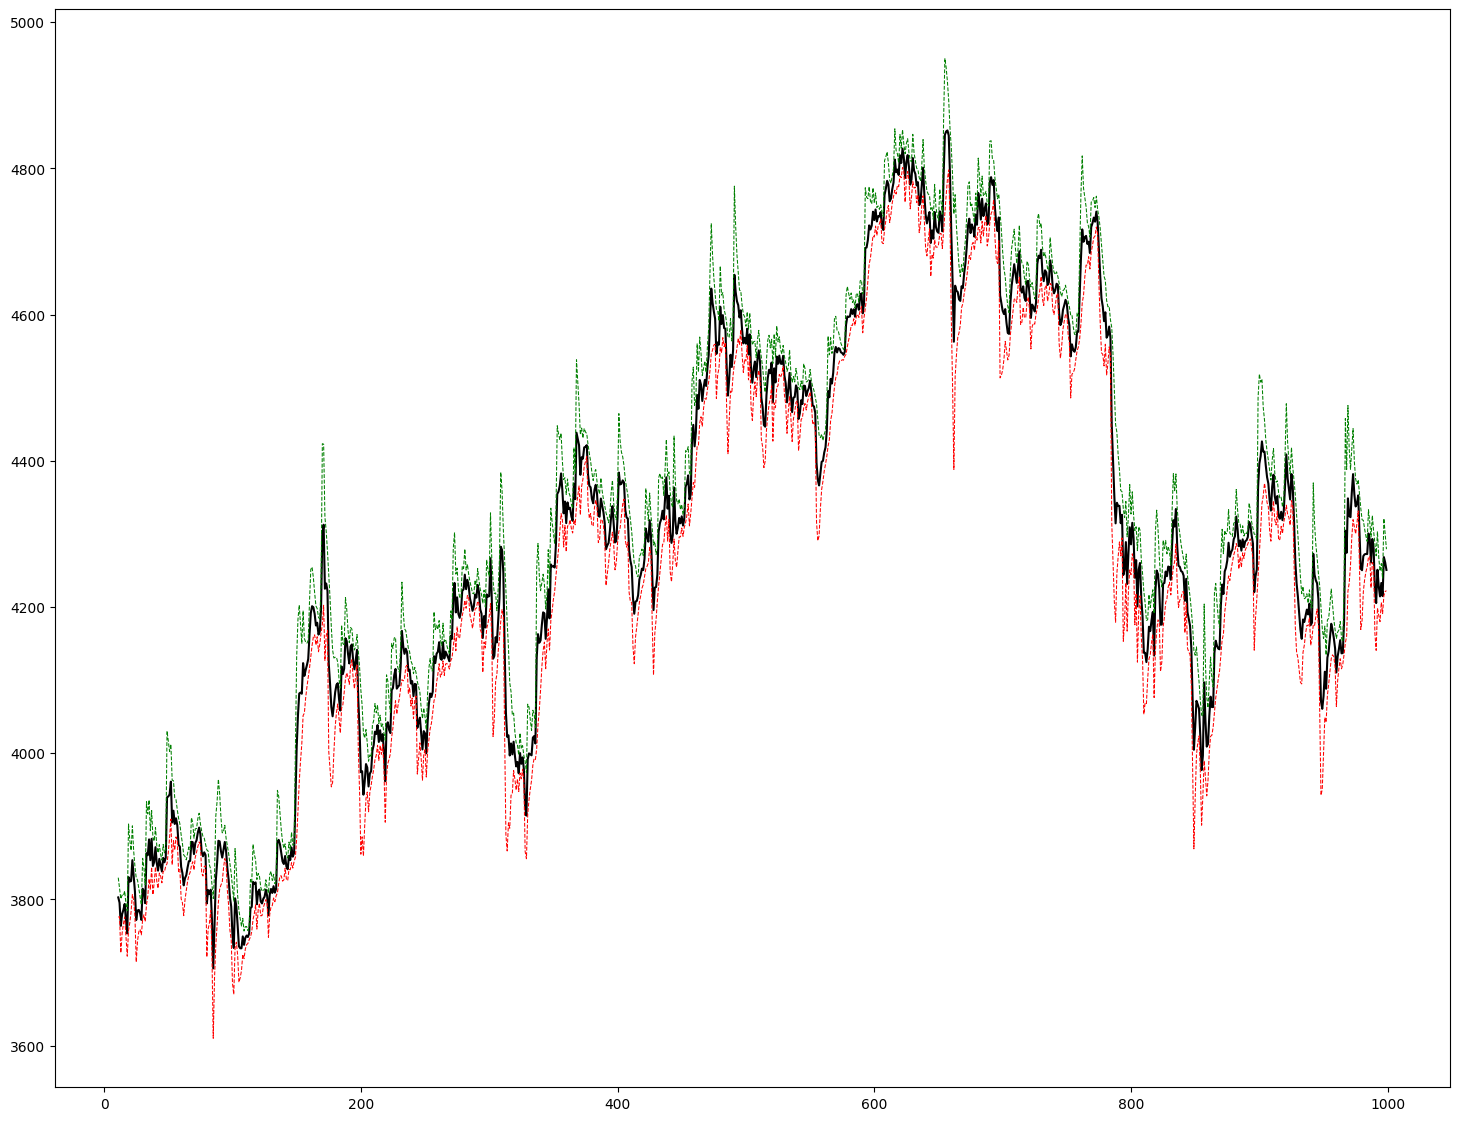

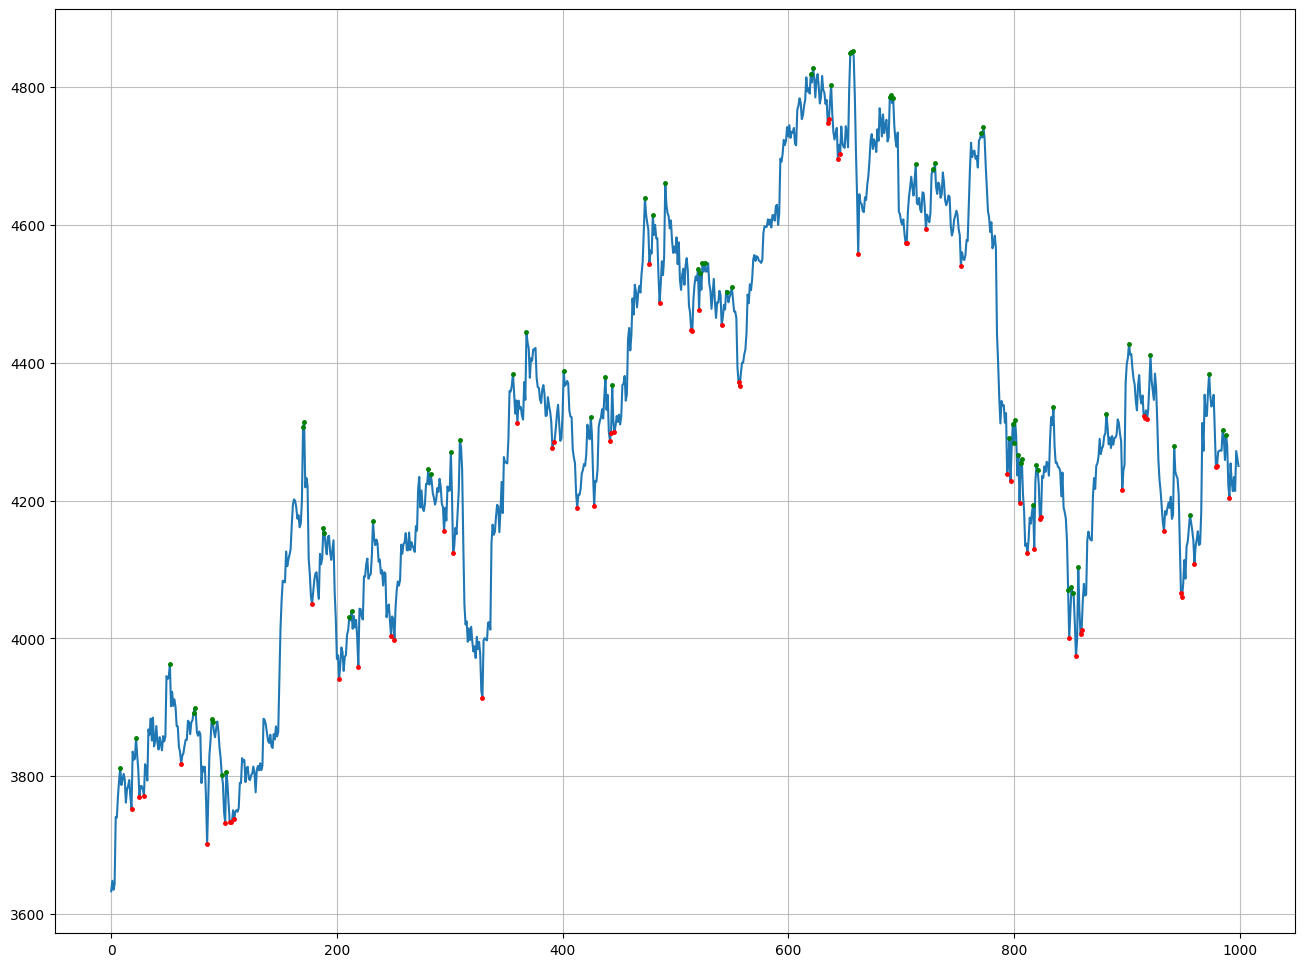

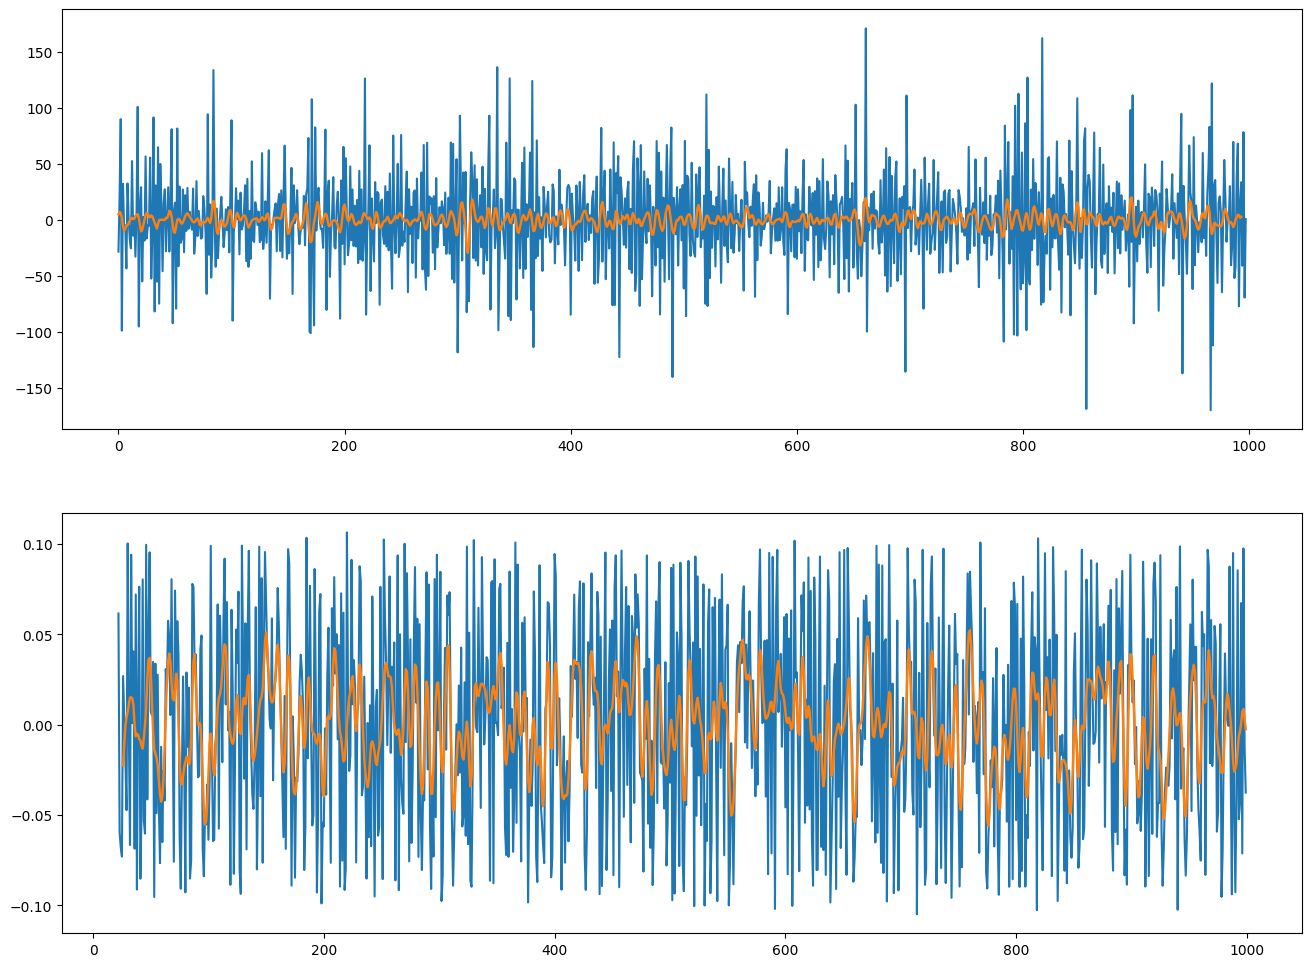

In [56]:
(f1, a1), (f2, a2), (f3, axs) = sdb.plot_data()

In [59]:
sdb[0]

(open_time                       2021-10-14 07:00:00
 open                                        3629.65
 high                                        3640.68
 low                                          3621.1
 close                                        3632.8
 volume                                    37276.789
 quote_asset_volume                  135379014.91988
 trades                                        66924
 taker_buy_volume                          19137.308
 taker_buy_quote_asset_volume         69508217.51625
 closes_ema                                      NaN
 closes_std                                      NaN
 closes_z                                        NaN
 acc                                          -28.27
 filtered_acc                               5.026487
 filtered_z                                      NaN
 Name: 0, dtype: object,
 labels    0
 Name: 0, dtype: int64)

In [60]:
sdb.data = pd.concat([sdb.features, sdb.labels], axis=1).dropna()

In [61]:
sdb.data
sdb.features = sdb.data.drop(columns=['labels'])
sdb.labels = sdb.data['labels']


In [62]:
idx = 0
feature = sdb.features.iloc[idx:idx+1000, :]

In [63]:
feature

,open_time,open,high,low,close,volume,quote_asset_volume,trades,taker_buy_volume,taker_buy_quote_asset_volume,closes_ema,closes_std,closes_z,acc,filtered_acc,filtered_z
26,2021-10-15 09:00:00,3769.03,3787.39,3747.10,3785.55,70306.279,2.649893e+08,89984,37365.826,1.408638e+08,3784.680351,25.835250,0.026996,-4.58,5.709287,-0.022659
27,2021-10-15 10:00:00,3785.55,3786.00,3756.37,3785.54,49882.922,1.880994e+08,71365,22412.478,8.451656e+07,3785.486272,18.513967,0.004408,-5.09,2.702386,-0.011040
28,2021-10-15 11:00:00,3785.55,3795.00,3779.56,3780.95,41039.630,1.554132e+08,67144,19815.056,7.504227e+07,3781.233517,13.783790,-0.019008,55.71,2.459365,-0.000796
29,2021-10-15 12:00:00,3780.95,3796.03,3770.12,3771.27,44022.723,1.664391e+08,69965,21970.652,8.307666e+07,3771.892720,12.663283,-0.047290,-52.32,4.080981,0.004157
30,2021-10-15 13:00:00,3771.27,3838.53,3768.00,3817.30,92199.710,3.511361e+08,118981,47439.501,1.806500e+08,3814.462045,25.752046,0.100360,-11.13,3.283823,0.007085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,2021-11-24 12:00:00,4295.15,4314.96,4273.07,4279.73,49064.229,2.106033e+08,82117,25788.766,1.107009e+08,4280.559854,14.390478,-0.048120,39.28,2.334286,-0.025920
990,2021-11-24 13:00:00,4279.73,4310.08,4210.00,4222.21,112119.373,4.771686e+08,149041,54247.537,2.308283e+08,4225.856866,38.120422,-0.092695,68.20,4.793964,-0.024303
991,2021-11-24 14:00:00,4222.19,4248.77,4170.38,4203.97,148381.795,6.240676e+08,198810,71926.413,3.026216e+08,4205.337929,39.988668,-0.037863,-77.12,4.337398,-0.021673
992,2021-11-24 15:00:00,4203.98,4274.91,4195.93,4253.93,97545.740,4.134215e+08,135100,47616.851,2.017896e+08,4250.892996,32.403347,0.085501,13.95,1.954021,-0.014208
